In [1]:
import numpy as np
import pandas as pd 
import torch 
import matplotlib.pyplot as plt 

In [2]:
import os 
os.chdir('/kaggle/input/data-diff')

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class SuperresDataset(Dataset):
    def __init__(self, hr_images, lr_images, max_images=None):
        """
        Initialize the SuperresDataset.

        Parameters:
        - hr_images (list of ndarray): High-resolution images.
        - lr_images (list of ndarray): Low-resolution images.
        - max_images (int, optional): Maximum number of images to use.
        """
        self.hr_images = [torch.tensor(img, dtype=torch.float32) for img in hr_images]
        self.lr_images = [torch.tensor(img, dtype=torch.float32) for img in lr_images]
        
        if max_images is not None:
            self.hr_images = self.hr_images[:max_images]
            self.lr_images = self.lr_images[:max_images]
        
    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        """
        Get the interpolated low-resolution image and high-resolution image at the specified index.

        Parameters:
        - idx (int): Index of the image to retrieve.

        Returns:
        - tuple of torch.Tensor: Interpolated low-resolution image and high-resolution image.
        """
        hr = self.hr_images[idx]
        lr = self.lr_images[idx]
        
        # Ensure LR and HR images are 4D (N, C, H, W) for interpolation
        if len(lr.shape) == 2:  # If single channel 2D image
            lr = lr.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
            hr = hr.unsqueeze(0).unsqueeze(0)
        elif len(lr.shape) == 3:  # If 3D (C, H, W) image
            lr = lr.unsqueeze(0)
            hr = hr.unsqueeze(0)
        
        # Interpolate LR image to the size of HR image
        lr_interpolated = F.interpolate(lr, size=hr.shape[2:], mode='bilinear', align_corners=False)
        
        return lr_interpolated.squeeze(0), hr.squeeze(0)

In [8]:
hr_images = np.load('HR_new.npy')
lr_images = np.load('LR_new.npy')


In [9]:
import numpy as np
import torch
from torch.utils.data import DataLoader

total_samples = len(hr_images)
train_size = int(0.90 * total_samples)
test_size = total_samples - train_size
indices = np.arange(total_samples)
np.random.shuffle(indices)
train_indices, test_indices = indices[:train_size], indices[train_size:]

train_dataset = SuperresDataset([hr_images[i] for i in train_indices], [lr_images[i] for i in train_indices])
test_dataset = SuperresDataset([hr_images[i] for i in test_indices], [lr_images[i] for i in test_indices])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
def check_for_nans(data_loader):
    for batch_idx, (lr, hr) in enumerate(data_loader):
        if torch.isnan(lr).any():
            print(f"NaN values found in LR images in batch {batch_idx}")
        if torch.isnan(hr).any():
            print(f"NaN values found in HR images in batch {batch_idx}")

check_for_nans(train_dataloader)

In [ ]:
import numpy as np
import torch.nn.functional as F
import torch 

def cosine_beta_schedule(timesteps, s=0.008):
    steps = torch.arange(timesteps, dtype=torch.float32) / timesteps
    cosine_schedules = torch.cos(((steps + s) / (1 + s)) * np.pi * 0.5)
    betas = 1 - cosine_schedules**2
    return betas.clamp(min=0.0001, max=0.9999)

def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)   
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

T = 1000
betas = cosine_beta_schedule(T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [ ]:
import torch
from torch import nn
import math

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 2  # Noisy image and LR image
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i + 1], time_emb_dim) for i in range(len(down_channels) - 1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i + 1], time_emb_dim, up=True) for i in range(len(up_channels) - 1)])
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, noisy_img, lr_img, timestep):
        t = self.time_mlp(timestep)
        x = torch.cat((noisy_img, lr_img), dim=1)  # Concatenate along channel dimension
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
model = SimpleUnet().to(device)    
model.to(device)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

Using 2 GPUs!


In [20]:
# Loading the Model
# model_path = '/kaggle/working/SR3.pth'
# model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [ ]:
from tqdm import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}/{epochs}", unit='batch') as pbar:
        for step, (lr, hr) in enumerate(train_dataloader):
            lr, hr = lr.to(device), hr.to(device)

            optimizer.zero_grad()
            
            timesteps = torch.randint(0, T, (lr.size(0),), device=device).long()  
            noisy_lr, noise = forward_diffusion_sample(lr, timesteps, device=device)
            
            predicted_hr = model(noisy_lr, lr, timesteps)
            loss = nn.L1Loss()(predicted_hr, hr)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
            pbar.update(1)
    
    epoch_loss /= len(train_dataloader)
    print(f"End of Epoch {epoch+1} | Avg Loss: {epoch_loss:.8f}")


Epoch 1/30: 100%|██████████| 638/638 [01:34<00:00,  6.74batch/s, loss=0.0104] 


End of Epoch 1 | Avg Loss: 0.01725638


Epoch 2/30: 100%|██████████| 638/638 [01:34<00:00,  6.76batch/s, loss=0.0095] 


End of Epoch 2 | Avg Loss: 0.01707550


Epoch 3/30: 100%|██████████| 638/638 [01:34<00:00,  6.75batch/s, loss=0.00865]


End of Epoch 3 | Avg Loss: 0.01744913


Epoch 4/30: 100%|██████████| 638/638 [01:34<00:00,  6.74batch/s, loss=0.0125] 


End of Epoch 4 | Avg Loss: 0.01727732


Epoch 5/30: 100%|██████████| 638/638 [01:34<00:00,  6.74batch/s, loss=0.00788]


End of Epoch 5 | Avg Loss: 0.01687467


Epoch 6/30: 100%|██████████| 638/638 [01:34<00:00,  6.74batch/s, loss=0.00721]


End of Epoch 6 | Avg Loss: 0.01668320


Epoch 7/30: 100%|██████████| 638/638 [01:34<00:00,  6.74batch/s, loss=0.00777]


End of Epoch 7 | Avg Loss: 0.01648239


Epoch 8/30: 100%|██████████| 638/638 [01:34<00:00,  6.72batch/s, loss=0.00753]


End of Epoch 8 | Avg Loss: 0.01664211


Epoch 9/30:  56%|█████▌    | 357/638 [00:52<00:41,  6.85batch/s, loss=0.0113] 

In [133]:
torch.save(model.state_dict(), '/kaggle/working/SR3.pth')

In [23]:
import torch
import numpy as np
from torch import nn
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def calculate_psnr(img1, img2):
    mse = nn.functional.mse_loss(img1, img2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def calculate_ssim(img1, img2, data_range=1.0, win_size=11):
    img1 = img1.squeeze().cpu().numpy()
    img2 = img2.squeeze().cpu().numpy()
    return structural_similarity(img1, img2, win_size=win_size, data_range=data_range, multichannel=False)

def evaluate_model(model, dataloader, win_size=11, data_range=1.0):
    model.eval()
    mse_lr_hr = 0.0
    mse_lr_predhr = 0.0
    mse_hr_predhr = 0.0
    psnr_lr_hr = 0.0
    psnr_lr_predhr = 0.0
    psnr_hr_predhr = 0.0
    ssim_lr_hr = 0.0
    ssim_lr_predhr = 0.0
    ssim_hr_predhr = 0.0
    num_samples = 0

    with torch.no_grad():
        for step, (lr, hr) in enumerate(dataloader):
            lr, hr = lr.to(device), hr.to(device)
            timesteps = torch.randint(0, T, (lr.size(0),), device=device).long()
            noisy_lr, _ = forward_diffusion_sample(lr, timesteps, device=device)
            predicted_hr = model(noisy_lr, lr, timesteps)

            # Loop over each image in the batch
            batch_size = lr.size(0)
            for i in range(batch_size):
                mse_lr_hr += nn.MSELoss()(lr[i], hr[i]).item()
                mse_lr_predhr += nn.MSELoss()(lr[i], predicted_hr[i]).item()
                mse_hr_predhr += nn.MSELoss()(hr[i], predicted_hr[i]).item()

                psnr_lr_hr += calculate_psnr(lr[i], hr[i])
                psnr_lr_predhr += calculate_psnr(lr[i], predicted_hr[i])
                psnr_hr_predhr += calculate_psnr(hr[i], predicted_hr[i])

                ssim_lr_hr += calculate_ssim(lr[i], hr[i], data_range, win_size)
                ssim_lr_predhr += calculate_ssim(lr[i], predicted_hr[i], data_range, win_size)
                ssim_hr_predhr += calculate_ssim(hr[i], predicted_hr[i], data_range, win_size)

                num_samples += 1

    mse_lr_hr /= num_samples
    mse_lr_predhr /= num_samples
    mse_hr_predhr /= num_samples
    psnr_lr_hr /= num_samples
    psnr_lr_predhr /= num_samples
    psnr_hr_predhr /= num_samples
    ssim_lr_hr /= num_samples
    ssim_lr_predhr /= num_samples
    ssim_hr_predhr /= num_samples

    print(f"Avg MSE (LR, HR): {mse_lr_hr:.8f}")
    print(f"Avg MSE (LR, Predicted HR): {mse_lr_predhr:.8f}")
    print(f"Avg MSE (HR, Predicted HR): {mse_hr_predhr:.8f}")
    print(f"Avg PSNR (LR, HR): {psnr_lr_hr:.8f}")
    print(f"Avg PSNR (LR, Predicted HR): {psnr_lr_predhr:.8f}")
    print(f"Avg PSNR (HR, Predicted HR): {psnr_hr_predhr:.8f}")
    print(f"Avg SSIM (LR, HR): {ssim_lr_hr:.8f}")
    print(f"Avg SSIM (LR, Predicted HR): {ssim_lr_predhr:.8f}")
    print(f"Avg SSIM (HR, Predicted HR): {ssim_hr_predhr:.8f}")

evaluate_model(model, test_dataloader)

Avg MSE (LR, HR): 0.03599425
Avg MSE (LR, Predicted HR): 0.03068901
Avg MSE (HR, Predicted HR): 0.00259170
Avg PSNR (LR, HR): 16.92660904
Avg PSNR (LR, Predicted HR): 17.43454742
Avg PSNR (HR, Predicted HR): 28.81042290
Avg SSIM (LR, HR): 0.55272966
Avg SSIM (LR, Predicted HR): 0.57685234
Avg SSIM (HR, Predicted HR): 0.85404873


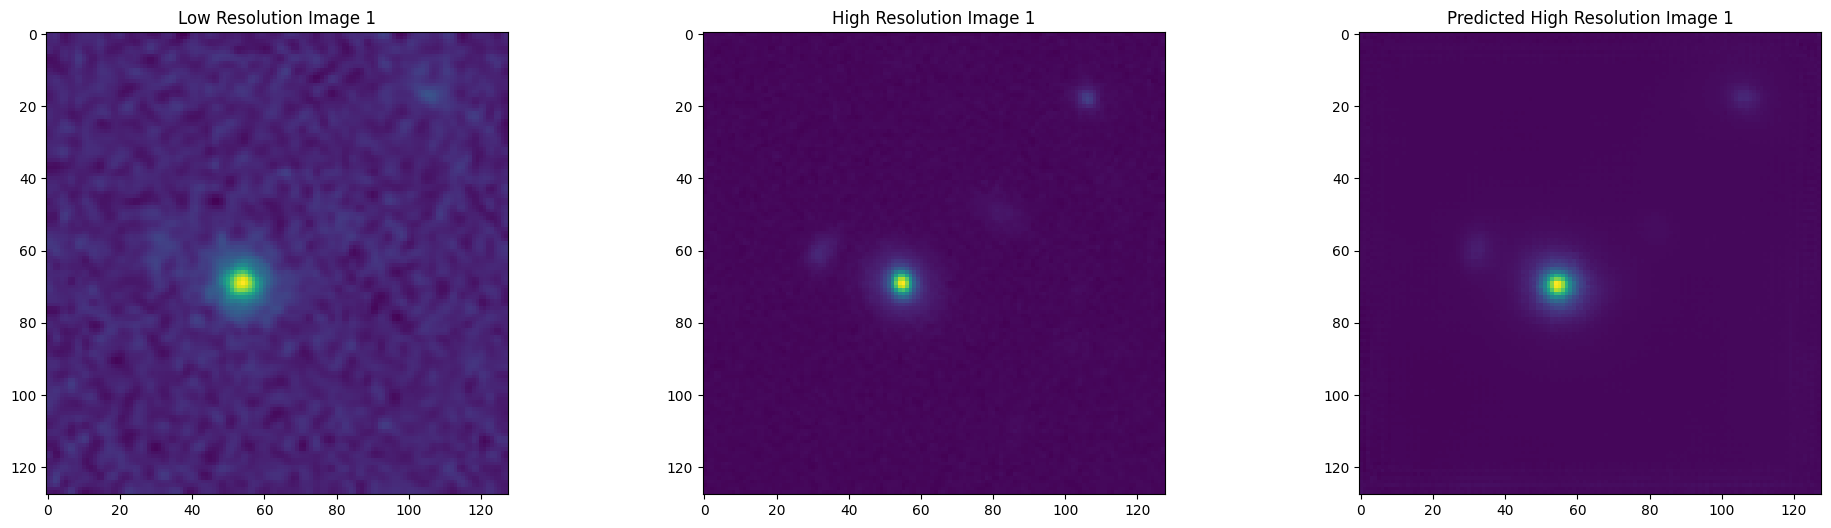

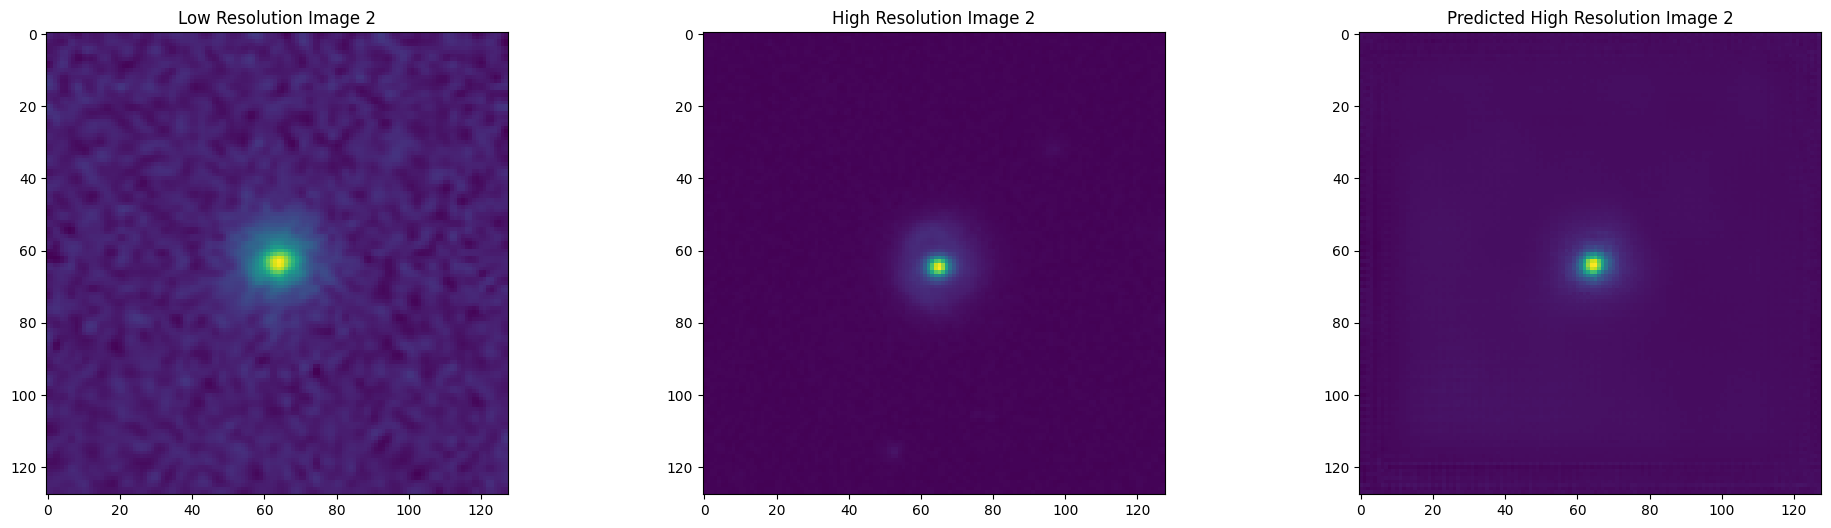

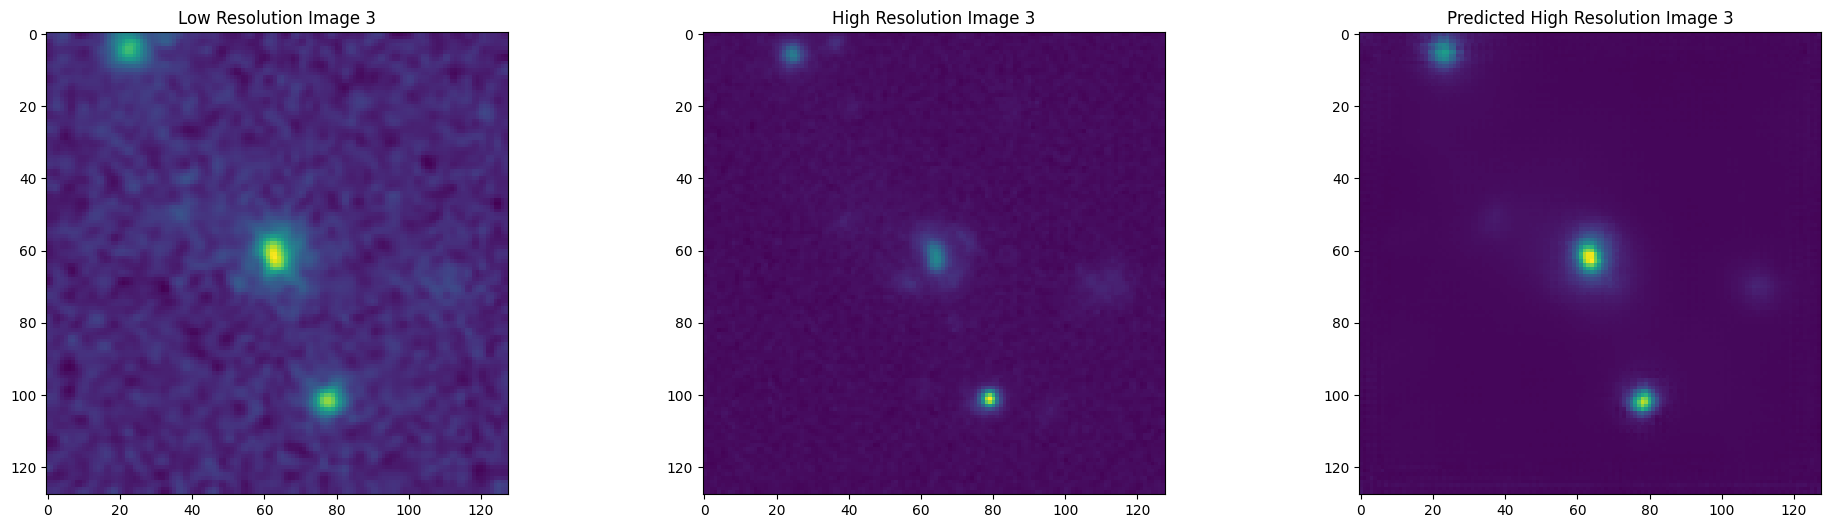

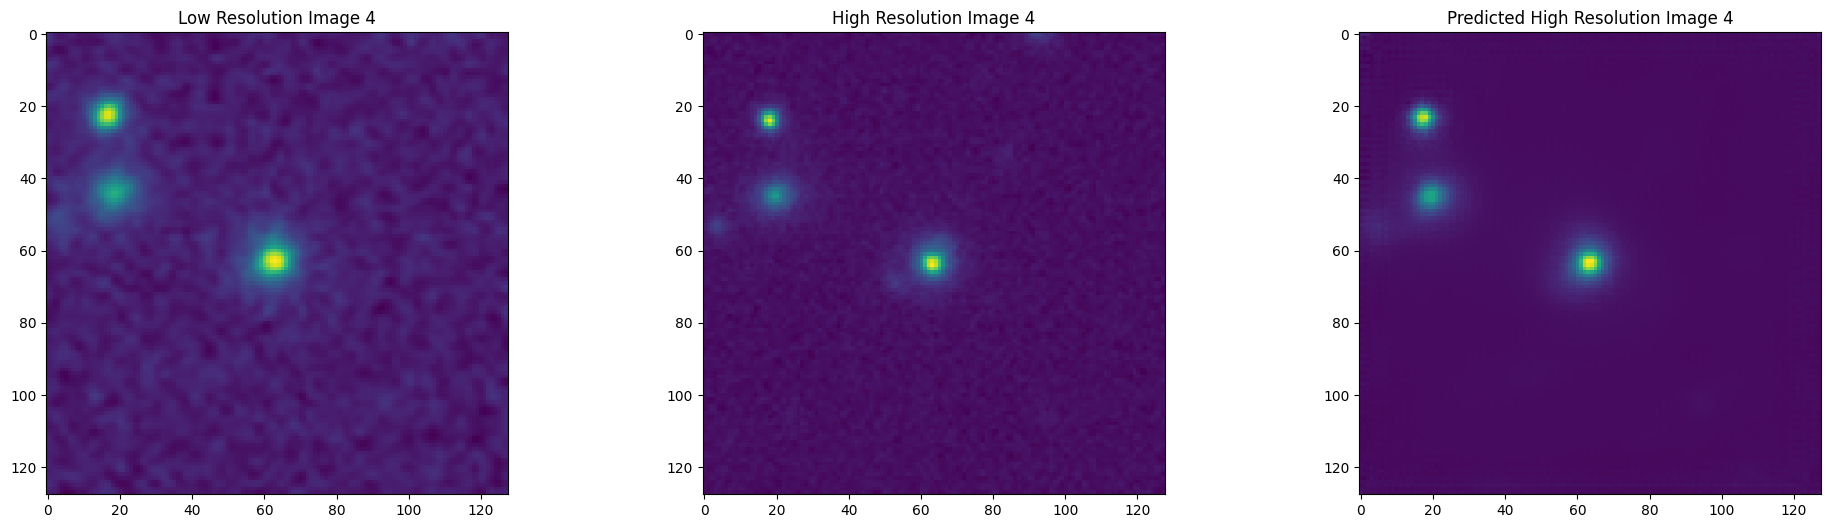

In [24]:
import matplotlib.pyplot as plt

model.eval()

for i, (lr_batch, hr_batch) in enumerate(test_dataloader):
    if i >= 1:  
        break

    lr_batch, hr_batch = lr_batch.to(device), hr_batch.to(device)
    
    timesteps = torch.randint(0, 1000, (lr_batch.size(0),), device=device).long()
    with torch.no_grad():
        noisy_lr_batch, _ = forward_diffusion_sample(lr_batch, timesteps, device=device)
        pred_hr_batch = model(noisy_lr_batch, lr_batch, timesteps)
    
    lr_batch = lr_batch.cpu().detach()
    hr_batch = hr_batch.cpu().detach()
    noisy_lr_batch = noisy_lr_batch.cpu().detach()
    pred_hr_batch = pred_hr_batch.cpu().detach()
    
    for j in range(lr_batch.size(0)):  # Iterate through each image in the batch
        lr = lr_batch[j].squeeze()
        hr = hr_batch[j].squeeze()
        noisy_lr = noisy_lr_batch[j].squeeze()
        pred_hr = pred_hr_batch[j].squeeze()
        
        plt.figure(figsize=(24, 6))
        
        plt.subplot(1, 3, 1)
        plt.imshow(lr, cmap='viridis')
        plt.title(f'Low Resolution Image {i*lr_batch.size(0) + j + 1}')
        
        plt.subplot(1, 3, 2)
        plt.imshow(hr, cmap='viridis')
        plt.title(f'High Resolution Image {i*lr_batch.size(0) + j + 1}')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_hr, cmap='viridis')
        plt.title(f'Predicted High Resolution Image {i*lr_batch.size(0) + j + 1}')
        
        plt.show()